# Experiments with German

In [1]:
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.inspection import PartialDependenceDisplay
from lime import lime_tabular
import shap
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import OrdinalEncoder
from aif360.algorithms.preprocessing import Reweighing
from fairlearn.postprocessing import ThresholdOptimizer
from fairgbm import FairGBMClassifier
from aif360.datasets import BinaryLabelDataset
from sklego.linear_model import EqualOpportunityClassifier, DemographicParityClassifier
import plotly.express as px
import plotly.graph_objects as go
import joblib


import credit_pipeline.data_exploration as dex
from credit_pipeline.training import *


%load_ext autoreload
%autoreload 2

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'


## Loading and Cleaning

In [2]:
seed_number = 0

In [3]:
path = "../data/German/"
df = dex.read_csv_encoded(path, 'german_raw.csv')

In [4]:
columns_to_drop = dex.check_missing(df, 50,  False)
columns_to_drop

[]

In [5]:
df_cols = df.columns.to_list()
obj_cols = dex.list_by_type(df, ['O'])
obj_cols

['Gender', 'PurposeOfLoan']

In [6]:
print(dex.list_no_variation_cols(df))
print(dex.list_contin_cols(df))
print(dex.list_by_unique(df, 2))

[]
[]
['GoodCustomer', 'Gender', 'ForeignWorker', 'Single', 'NumberOfLiableIndividuals', 'HasTelephone', 'CheckingAccountBalance_geq_0', 'CheckingAccountBalance_geq_200', 'SavingsAccountBalance_geq_100', 'SavingsAccountBalance_geq_500', 'MissedPayments', 'NoCurrentLoan', 'CriticalAccountOrLoansElsewhere', 'OtherLoansAtBank', 'HasCoapplicant', 'HasGuarantor', 'OwnsHouse', 'RentsHouse', 'Unemployed', 'YearsAtCurrentJob_lt_1', 'YearsAtCurrentJob_geq_4', 'JobClassIsSkilled']


In [7]:
df.GoodCustomer = df.GoodCustomer.apply(lambda x: 1 if x == 1 else 0)

In [8]:
X_acp = df.iloc[:, (df.columns != "GoodCustomer")]
y_acp = df["GoodCustomer"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_acp, 
    y_acp, 
    test_size = 0.2, 
    random_state=seed_number, 
    stratify=y_acp
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size = 0.2, 
    random_state=seed_number, 
    stratify=y_train
)
A_train = (X_train.Gender == "Female").astype(int)
A_val = (X_val.Gender == "Female").astype(int)
A_test = (X_test.Gender == "Female").astype(int)

## Training Basic Models

In [10]:
n_trials = 100

In [11]:
classifiers = {
    "LogisticRegression": LogisticRegression,
    "RandomForest": RandomForestClassifier,
    "LightGBM": LGBMClassifier,
    "MLP" : MLPClassifier,
}

In [12]:
param_spaces = {
    "LogisticRegression": {
        'C': {'low': 0.001, 'high': 10, 'log': True, 'type':'float'},
        'max_iter': {'low': 1000, 'high': 1000, 'step':1, 'type':'int'},
        'penalty': {'choices': ["l1", 'l2'], 'type':'categorical'},
        "class_weight" : {"choices" : [None, "balanced"], 'type':'categorical'},
        "solver" : {"choices" : ["liblinear"], "type" : "categorical"}
    },
    "RandomForestClassifier": {
        'n_estimators': {'low':10, 'high':150, 'step':20, 'type':'int'},
        'max_depth': {'low':2, 'high':10, 'type':'int'},
        'criterion': {'choices':['gini', 'entropy'], 'type':'categorical'},
        'min_samples_leaf' : {"low" : 1, "high" : 51, "step" : 5, 'type':'int'},
        "max_features" : {"low" : 0.1, "high" : 1.0, "type" : "float"},
        "class_weight" : {"choices" : [None, "balanced"], 'type':'categorical'},
    },
    "LGBMClassifier": {
        'learning_rate': {'low': 0.01, 'high': 1.0, 'type': 'float', 'log': True},
        "num_leaves" : {"low" : 5, "high" : 100, "step" : 5, 'type':'int'},
        'max_depth': {'low': 2, 'high': 10, 'type': 'int'},
        'min_child_samples': {'low': 1, 'high': 51, 'step': 5, 'type': 'int'},
        'colsample_bytree': {'low': 0.1, 'high': 1.0, 'type': 'float'},
        'reg_alpha': {'low': 0.0, 'high': 1.0, 'type': 'float'},
        'reg_lambda': {'low': 0.0, 'high': 1.0, 'type': 'float'},
        'n_estimators': {'low': 5, 'high': 100, 'step': 5, 'type': 'int'},
        "class_weight" : {"choices" : [None, "balanced"], 'type':'categorical'},
        "verbose" : {"choices" : [-1], 'type':'categorical'},
    },
    "MLPClassifier": {
        "hidden_layer_sizes" : {"choices" : [
            [128, 64, 32],
            [128, 64, 32, 16],
            [256, 128, 64, 32, 16],
        ], 'type':'categorical'},
        "alpha" : {'low': 0.0001, 'high': 0.01, 'type': 'float', 'log': True},
        "learning_rate" : {'choices': ['constant', 'invscaling', 'adaptive'], 'type':'categorical'},
        "learning_rate_init" : {'low': 0.001, 'high': 0.1, 'type': 'float', 'log': True},
        "early_stopping" : {'choices': [True], 'type':'categorical'},
        "max_iter" : {"choices" : [50], 'type':'categorical'},
    }
}

In [ ]:
study_logistic, model_logistic = optimize_model(LogisticRegression, param_spaces["LogisticRegression"], X_train, y_train, X_val , y_val, n_trials=n_trials)
joblib.dump(model_logistic, "models/german_logistic.joblib")

In [32]:
print("Score for Logistic Regression: ", study_logistic.best_value)
print(study_logistic.best_params)

Score for Logistic Regression:  0.7206101190476191
{'C': 0.0010076392957269137, 'max_iter': 1000, 'penalty': 'l2', 'class_weight': 'balanced', 'solver': 'liblinear'}


In [ ]:
study_rf, model_rf = optimize_model(RandomForestClassifier, param_spaces["RandomForestClassifier"], X_train, y_train, X_val , y_val, n_trials=n_trials)
joblib.dump(model_rf, "models/german_rf.joblib")

In [34]:
print("Score for Random Forest: ", study_rf.best_value)
print(study_rf.best_params)

Score for Random Forest:  0.7658110119047619
{'n_estimators': 130, 'max_depth': 4, 'criterion': 'entropy', 'min_samples_leaf': 1, 'max_features': 0.21386703871573098, 'class_weight': None}


In [ ]:
study_lgbm, model_lgbm = optimize_model(LGBMClassifier, param_spaces["LGBMClassifier"], X_train, y_train, X_val, y_val, n_trials=n_trials)
joblib.dump(model_lgbm, "models/german_lgbm.joblib")

In [36]:
print("Score for LGBM: ", study_lgbm.best_value)
print(study_lgbm.best_params)

Score for LGBM:  0.763671875
{'learning_rate': 0.036180153812084594, 'num_leaves': 15, 'max_depth': 10, 'min_child_samples': 1, 'colsample_bytree': 0.46131912757227833, 'reg_alpha': 0.38241615918664634, 'reg_lambda': 0.7391523771170821, 'n_estimators': 10, 'class_weight': None, 'verbose': -1}


In [ ]:
study_mlp, model_mlp = optimize_model(MLPClassifier, param_spaces["MLPClassifier"], X_train, y_train, X_val , y_val, n_trials=n_trials)
joblib.dump(model_mlp, "models/german_mlp.joblib")

In [38]:
print("Score for MLP: ", study_mlp.best_value)
print(study_mlp.best_params)

Score for MLP:  0.7336309523809524
{'hidden_layer_sizes': [128, 64, 32, 16], 'alpha': 0.005641404688490753, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0011283714315737572, 'early_stopping': True, 'max_iter': 50}


## Model evaluation

In [13]:
models = {
    "LogisticRegression" : joblib.load("models/german_logistic.joblib"),
    "MLP" : joblib.load("models/german_mlp.joblib"),
    "RandomForest" : joblib.load("models/german_rf.joblib"),
    "LightGBM" : joblib.load("models/german_lgbm.joblib"),
}
ks_threshold_dict = {}
models_dict = {}
for n, m in models.items():
    ks_threshold_dict[n] = ks_threshold(y_val, m.predict_proba(X_val)[:,1])
    models_dict[n] = [
        m,
        ks_threshold_dict[n]
    ]

In [27]:
get_metrics(models_dict, X_train, y_train)

,AUC,Balanced Accuracy,Accuracy,Precision,Recall,F1,Brier Score
LogisticRegression,0.730294,0.643229,0.717187,0.781053,0.828125,0.803900,0.236953
MLP,0.792329,0.692708,0.615625,0.910569,0.500000,0.645533,0.169949
RandomForest,0.869734,0.779390,0.751563,0.916427,0.709821,0.800000,0.169144
LightGBM,0.890009,0.760045,0.695312,0.946996,0.598214,0.733242,0.193634


In [28]:
get_metrics(models_dict, X_val, y_val)

,AUC,Balanced Accuracy,Accuracy,Precision,Recall,F1,Brier Score
LogisticRegression,0.720610,0.671131,0.75625,0.792000,0.883929,0.835443,0.233414
MLP,0.733631,0.687500,0.63750,0.875000,0.562500,0.684783,0.180909
RandomForest,0.765811,0.732143,0.72500,0.869565,0.714286,0.784314,0.183703
LightGBM,0.763672,0.724702,0.68125,0.896104,0.616071,0.730159,0.199130


In [29]:
get_metrics(models_dict, X_test, y_test)

,AUC,Balanced Accuracy,Accuracy,Precision,Recall,F1,Brier Score
LogisticRegression,0.804762,0.685714,0.760,0.802632,0.871429,0.835616,0.233721
MLP,0.776310,0.692857,0.630,0.892857,0.535714,0.669643,0.177589
RandomForest,0.808095,0.725000,0.715,0.867257,0.700000,0.774704,0.181101
LightGBM,0.805119,0.708333,0.645,0.905882,0.550000,0.684444,0.198999


In [14]:
models_dict_fairness = {}
for n, m in models_dict.items():
    models_dict_fairness[n] = (m[0].predict_proba(X_test)[:,1] > m[1]).astype(int)

In [15]:
get_fairness_metrics(models_dict_fairness, y_test, A_test, 1)

,DPD,EOD,AOD,APVD,GMA,balanced_accuracy
LogisticRegression,-0.178590,-0.148966,-0.129428,-0.021941,0.734643,0.685714
MLP,-0.296296,-0.344095,-0.214172,-0.044716,0.589955,0.692857
RandomForest,-0.190512,-0.122911,-0.143873,-0.047802,0.711399,0.725000
LightGBM,-0.194825,-0.115548,-0.160338,-0.009961,0.648145,0.704762


## Fairness

In [16]:
pipeline_preprocess = create_pipeline(
    X_train,
    y_train,
    lambda x : x,
)[:-1]
pipeline_preprocess.fit(X_train, y_train)
preprocess_column_names = pipeline_preprocess.get_feature_names_out()
X_train_preprocess = pipeline_preprocess.transform(X_train)
X_val_preprocess = pipeline_preprocess.transform(X_val)
X_test_preprocess = pipeline_preprocess.transform(X_test)

### Pre-processing (Reweighing / AIF360)

In [17]:
df_rw = pd.DataFrame(
    X_train_preprocess,
    columns = preprocess_column_names
)
df_rw["GoodCustomer"] = y_train.values
x_train_aif = BinaryLabelDataset(
    df = df_rw,
    label_names = ["GoodCustomer"],
    protected_attribute_names = ["cat__Gender_Female"]
)
rw = Reweighing(
    unprivileged_groups = [{"cat__Gender_Female": 1}],
    privileged_groups = [{"cat__Gender_Female": 0}],
)
rw.fit(x_train_aif)
rw_weights = rw.transform(x_train_aif).instance_weights

In [18]:
for n in ["LogisticRegression", "RandomForest", "LightGBM"]:
    best_params = models[n]["classifier"].get_params()
    rw_model = classifiers[n](**best_params)
    rw_model.fit(X_train_preprocess, y_train, sample_weight=rw_weights)
    rw_threshold = ks_threshold(y_val, rw_model.predict_proba(X_val_preprocess)[:,1])
    models_dict_fairness[n + "Reweighing"] = rw_model.predict_proba(X_test_preprocess)[:,1] > rw_threshold

### In-processing

#### EqualOpportunityClassifier

In [19]:
gender_col_idx = np.where(preprocess_column_names == "cat__Gender_Female")[0][0]
eop_class = create_pipeline(
    X_train,
    y_train,
    EqualOpportunityClassifier(
        covariance_threshold = 0.1,
        sensitive_cols = gender_col_idx,
        positive_target = 1
    )
)
eop_class.fit(X_train, y_train)
eoq_ks_threshold = ks_threshold(y_val, eop_class.predict_proba(X_val)[:,1])
models_dict_fairness["EqualOpportunity"] = eop_class.predict_proba(X_test)[:,1] > eoq_ks_threshold
dop_class = create_pipeline(
    X_train,
    y_train,
    DemographicParityClassifier(
        covariance_threshold = 0.1,
        sensitive_cols = gender_col_idx,
    )
)
dop_class.fit(X_train, y_train)
dop_ks_threshold = ks_threshold(y_val, dop_class.predict_proba(X_val)[:,1])
models_dict_fairness["DemographicParity"] = dop_class.predict_proba(X_test)[:,1] > dop_ks_threshold

#### FairGBM

In [20]:
fairgbm_params = models["LightGBM"]["classifier"].get_params()
del fairgbm_params["objective"]
fairgbm = FairGBMClassifier(
    constraint_type="FNR",
    **fairgbm_params
)
fairgbm.fit(X_train_preprocess, y_train, constraint_group=A_train)
fairgbm_threshold = ks_threshold(y_val, fairgbm.predict_proba(X_val_preprocess)[:,1])
models_dict_fairness["FairGBM"] =fairgbm.predict_proba(X_test_preprocess)[:,1] > fairgbm_threshold

### Post-processing (Threshold-Optimizer / FairLearn)

In [21]:
model_dict_thr_opt = {}
for name, model in models_dict.items():
    thr_opt = ThresholdOptimizer(
        estimator=model[0],
        constraints="equalized_odds",
        objective="balanced_accuracy_score",
        prefit=True,
        predict_method="predict_proba",
    )
    thr_opt.fit(X_train, y_train, sensitive_features=A_train)
    models_dict_fairness[name + "Thr.Opt."] = thr_opt.predict(X_test, sensitive_features=A_test)

### Fairness Evaluation

In [22]:
df_metrics_results = get_fairness_metrics(
    models_dict_fairness,
    y_test,
    A_test,
    1
)
df_metrics_results_ = df_metrics_results.copy().reset_index()
df_metrics_results_.to_csv("results/german_fairness_metrics.csv", index=False)

In [24]:
df_metrics_results_[["index", "AOD", "balanced_accuracy"]].round(3)

,index,AOD,balanced_accuracy
0,LogisticRegression,-0.129,0.686
1,MLP,-0.214,0.693
2,RandomForest,-0.144,0.725
3,LightGBM,-0.160,0.705
4,LogisticRegressionReweighing,-0.058,0.727
5,RandomForestReweighing,0.006,0.713
6,LightGBMReweighing,-0.024,0.742
7,EqualOpportunity,0.024,0.710
8,DemographicParity,0.000,0.718
9,FairGBM,-0.160,0.705


In [16]:
# Mapping each model to a unique color
color_mapping = {model: idx for idx, model in enumerate(df_metrics_results_["index"].unique())}

# Adjust fairness metrics to be "the higher the better" and scale them to be between 0 and 100
#for col in ['DPD', 'EOD', 'AOD', 'APVD']:
#    df_metrics_results_[col] = (1 - np.abs(df_metrics_results_[col])) * 100

# Scale the performance metrics to be between 0 and 100
#df_metrics_results_['GMA'] *= 100
#df_latest_adjusted['balanced_accuracy'] *= 100

# Generate the required number of colors from the Viridis colorscale
num_colors = len(color_mapping)
#colors = px.colors.qualitative.Dark2
colors = px.colors.sequential.Viridis
manual_colors = [colors[i * (len(colors) - 1) // (num_colors - 1)] for i in range(num_colors)]                                                              
# Create the Advanced Parallel Coordinates Plot with adjusted data
fig = go.Figure(data=
    go.Parcoords(
        line=dict(color=df_metrics_results_['index'].map(color_mapping), showscale=False),
        dimensions=[
            dict(label='DPD', values=df_metrics_results_['DPD'], range=[-0.35, 0.1]),
            dict(label='EOD', values=df_metrics_results_['EOD'], range=[-0.35, 0.1]),
            dict(label='AOD', values=df_metrics_results_['AOD'], range=[-0.35, 0.1]),
            dict(label='APVD', values=df_metrics_results_['APVD'], range=[-0.35, 0.1]),
            dict(label='-1 * GMA', values= -df_metrics_results_['GMA']),#, range=[0, 100]),
            dict(label='-1 * Balanced Acc.', values= - df_metrics_results_['balanced_accuracy'])#, range=[65, 100])
        ]
    )
)

# Add models to the legend using the dummy scatter plot approach and specified manual colors
for idx, (model, color) in enumerate(color_mapping.items()):
    fig.add_trace(
        go.Scatter(x=[None], y=[None],
                   mode='markers',
                   marker=dict(size=10, color=manual_colors[idx]),
                   name=model,
                   showlegend=True)
    )

# remove grid from plot
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    font_color='black'
)

# remove xticks from plot
fig.update_xaxes(showticklabels=False)

# Update the layout and adjust the top margin
fig.update_layout(title='Fairness Metrics German', margin=dict(t=100))

# Show the plot
fig.show()

# save fig
fig.write_image("results/german_fairness_metrics.pdf")

## Explainability

### Preparing model and dataset for explainability

In [10]:
def columns_by_type(dataframe, types_cols = ['numeric'], debug=False):
    list_cols = []
    if types_cols == ['numeric']:
        types_cols = ['b','i','u','f','c']
    elif types_cols == ['categorical']:
        types_cols = ['O', 'S', 'U']

    # Iterate through each column in the DataFrame
    for c in dataframe.columns:
        col = dataframe[c]

        # Check if the column's data type matches any of the specified data types
        if (col.dtype.kind in types_cols) or (col.dtype in types_cols):
            list_cols.append(c)

            # Print debugging information if debug flag is enabled
            if debug:
                print(c, ' : ', col.dtype)
                print(col.unique()[:10])
                print('---------------')

    return list_cols

class EBE(BaseEstimator, TransformerMixin, ):
    def __init__(self, cols, k=None):
        self.k = k
        self.cols = cols

    def fit(self, X, y):
        self.feature_names_in_ = []
        self.n_features, self.n_items  = X.shape[1], X.shape[0]
        self._aux_dict_main = {}
        for i in range(self.n_features):
            Xi = X.iloc[:,i]
            X_name = X.iloc[:,i].name
            # print(X_name)

            y = pd.Series(y, index = X.index)
            aux_dict = (pd.Series(y)
                        .groupby(Xi)
                        .agg(["mean", "count"])
                        .to_dict())
            self._aux_dict_main[X_name] = aux_dict, y.mean(), y.count()
            self.feature_names_in_.append(X_name)

        # print(self._aux_dict_main[X_name][0])
        return self

    def transform(self, X, y=None):
        # print(X.shape)
        # self.cols = []
        Xt_list = []
        for i in range(self.n_features):
            Xi = X.iloc[:,i]
            X_name = X.iloc[:,i].name
            # self.cols.append(X_name)
            X_copy = Xi.copy()
            fit_unique = set(self._aux_dict_main[X_name][0]['mean'].keys())
            X_unique = set(Xi.unique())
            unknown_values = X_unique - fit_unique
            X_copy.loc[X_copy.isin(unknown_values)] = np.nan

            group_ave = X_copy.replace(self._aux_dict_main[X_name][0]['mean'])
            group_count = X_copy.replace(self._aux_dict_main[X_name][0]['count'])
            Xt = ((group_ave * group_count + self.k * self._aux_dict_main[X_name][1]) / (self.k + group_count)).values.reshape(-1, 1)
            Xt_list.append(Xt)
        Xt_array = np.hstack(Xt_list)
        # print(Xt_array.shape)
        return Xt_array

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.cols

        if isinstance(input_features, pd.DataFrame):
            return [col for col in input_features.columns]
        else:
            return [col for col in input_features]
        
class CustomNames(BaseEstimator, TransformerMixin):
    def fit(self, X, y):
        return self

    def transform(self, X):
        # Create a copy of X to avoid modifying the original DataFrame
        X_copy = X.copy()
        # print(X.columns)
        # Assign new column names to the DataFrame
        new_column_names = [col.split("__")[-1]  for col in X.columns]
        X_copy.columns = new_column_names

        return X_copy

    def get_feature_names_out(self, input_features=None):
        if isinstance(input_features, pd.DataFrame):
            return [col.split("__")[-1]  for col in input_features.columns]
        else:
            return [col.split("__")[-1]  for col in input_features]
        
def get_index_cols(data, cols):
        index_cols = []
        for c in cols:
            i = data.columns.get_loc(c)
            index_cols.append(i)
        return index_cols

#@title function to create a Pipeline that uses **EBE** given **X,y** and a **classifier(model)**
def create_pipeline(X, y, classifier = None, cat_cols = 'infer',
                    onehot = True, onehotdrop = False, normalize = False, do_EBE = False, crit = 3 ):
    num_cols = columns_by_type(X, ['numeric'])
    cat_cols = columns_by_type(X, ['categorical'])

    #check if need EBE
    if do_EBE:
        do_ebe_cols = []
        dont_ebe_cols = []
        for c in cat_cols:
            if len(X[c].unique()) >= crit:
                do_ebe_cols.append(c)
            else:
                dont_ebe_cols.append(c)
    else:
        do_ebe_cols, dont_ebe_cols = [], cat_cols

    index_num = get_index_cols(X, num_cols)
    index_cat = get_index_cols(X, dont_ebe_cols)
    index_ebe = get_index_cols(X, do_ebe_cols)

    #1 Fill NaNs

    numeric_nan_fill_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean'))
    ])

    categorical_nan_fill_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ])

    fill_pipe = ColumnTransformer(
        transformers=[
            ('num', numeric_nan_fill_transformer, index_num),
            ('cat', categorical_nan_fill_transformer, index_cat),
        ]
    )
    fill_pipe.set_output(transform="pandas")

    #2: Ordinal encoder

    encoder_pipe = ColumnTransformer(
        transformers=[
            ('num', "passthrough", make_column_selector(dtype_include=np.number)),
            ('cat', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value= 777), make_column_selector(dtype_exclude=np.number)),
        ]
    )

    encoder_pipe.set_output(transform="pandas")

    #3 Onehot encoder

    onehot_pipe = ColumnTransformer(
        transformers=[
        ('onehot_encoder', OneHotEncoder(drop='if_binary',
                                         sparse_output=False,
                                         handle_unknown="ignore") if onehotdrop else
                            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
         make_column_selector('cat')),
    ], remainder = 'passthrough')

    onehot_pipe.set_output(transform="pandas")

    #4 Scalling

    scaling_pipe = ColumnTransformer([
        ('scaler', StandardScaler(), make_column_selector('num')),
    ], remainder = 'passthrough')

    scaling_pipe.set_output(transform="pandas")

    #5 Better names

    name_pipe = Pipeline([
            ('names', CustomNames(), ),
    ])

    # Combine all the transformers in a single pipeline
    pipeline = Pipeline(
        steps=[
            ('fill', fill_pipe),
            ('le', encoder_pipe),
            ('hot', onehot_pipe if onehot else None),
            ('ss', scaling_pipe if normalize else None),
            ('name', name_pipe),
            ('classifier', classifier if classifier else None),
        ],
    )

    return pipeline

In [84]:
selected_model = "LightGBM"
best_params = {'learning_rate': 0.036180153812084594, 'num_leaves': 15, 'max_depth': 10, 'min_child_samples': 1, 'colsample_bytree': 0.46131912757227833, 'reg_alpha': 0.38241615918664634, 'reg_lambda': 0.7391523771170821, 'n_estimators': 10, 'class_weight': None, 'verbose': -1}

pipeline = create_pipeline(
    X_train,
    y_train,
    LGBMClassifier(**best_params),
)
pipeline.fit(X_train, y_train);
pipeline.score(X_test, y_test)

0.7

In [85]:
pipeline_preprocess = pipeline[:2]
pipeline_predict = pipeline[2:]

In [86]:
# input data to techniques
X_train_preprocess = pipeline_preprocess.transform(X_train)
X_val_preprocess = pipeline_preprocess.transform(X_val)
X_test_preprocess = pipeline_preprocess.transform(X_test)

In [87]:
features_names = X_train_preprocess.columns.to_list()
categorical_features = X_train_preprocess.columns.to_list()
categorical_features_names = [feat for feat in categorical_features if "cat_" in feat]
categorical_features = [features_names.index(feat) for feat in categorical_features_names]
categorical_names = {}
for i, feat in enumerate(categorical_features_names):
    idx = categorical_features[i]
    categorical_names[idx] = pipeline_preprocess[1].transformers_[1][1].categories_[i].tolist()
    categorical_names[idx] = dict([(i, cat) for i, cat in enumerate(categorical_names[idx])])

print(categorical_features_names)
print(categorical_names)

['cat__cat__Gender', 'cat__cat__PurposeOfLoan']
{27: {0: 'Female', 1: 'Male'}, 28: {0: 'Business', 1: 'Education', 2: 'Electronics', 3: 'Furniture', 4: 'HomeAppliances', 5: 'NewCar', 6: 'Other', 7: 'Repairs', 8: 'Retraining', 9: 'UsedCar'}}


### PDP

In [88]:
def PDP(Model, X, Features, Categorical):
    PartialDependenceDisplay.from_estimator(Model, X, Features, categorical_features=Categorical)

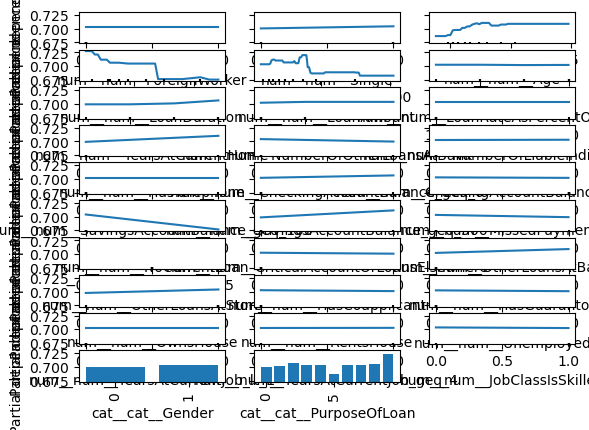

In [89]:
features = X_test_preprocess.columns
PDP(pipeline_predict, X_test_preprocess, features, categorical_features_names)

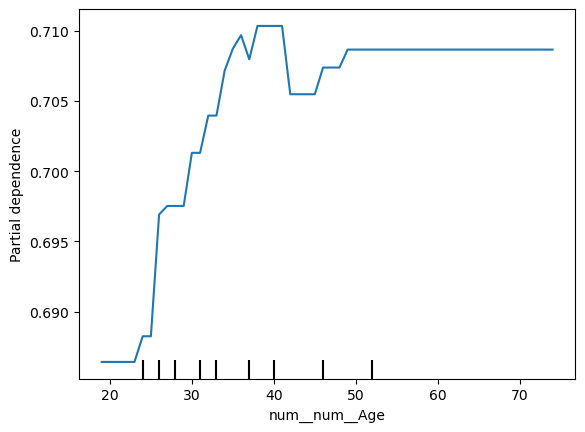

In [90]:
PDP(pipeline_predict, X_test_preprocess, ['num__num__Age'], categorical_features_names)

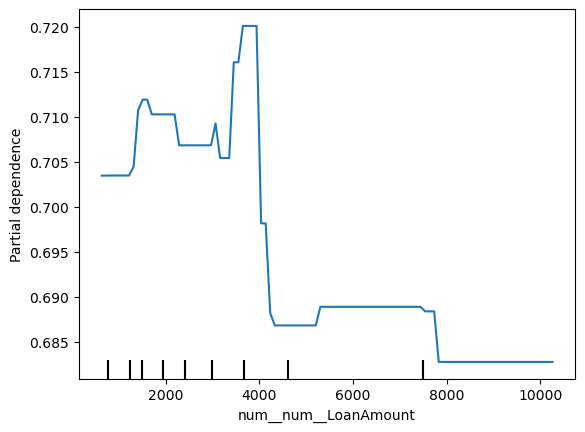

In [91]:
PDP(pipeline_predict, X_test_preprocess, ['num__num__LoanAmount'], categorical_features_names)

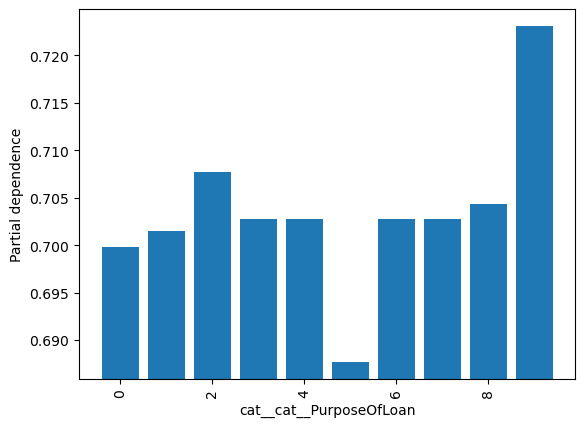

In [92]:
PDP(pipeline_predict, X_test_preprocess, ['cat__cat__PurposeOfLoan'], categorical_features_names)

### ICE

In [93]:
def ICE(Model, X, Features):
    PartialDependenceDisplay.from_estimator(Model, X, Features, kind='both')

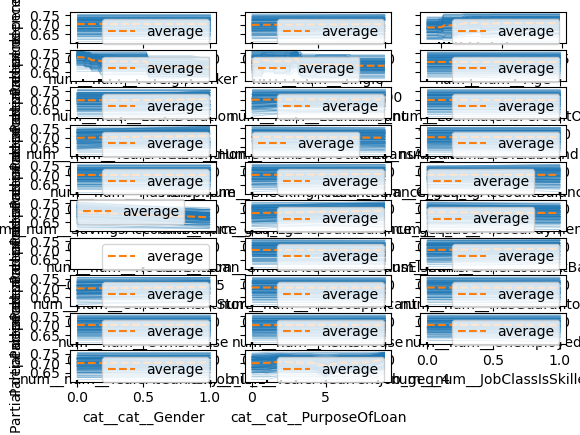

In [94]:
features = X_test_preprocess.columns
ICE(pipeline_predict, X_test_preprocess, features)

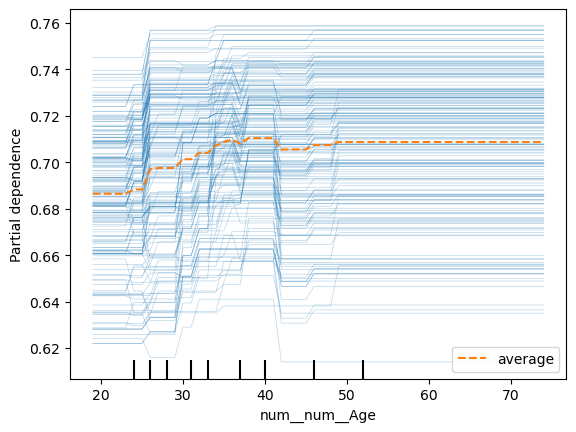

In [95]:
ICE(pipeline_predict, X_test_preprocess, ['num__num__Age'])

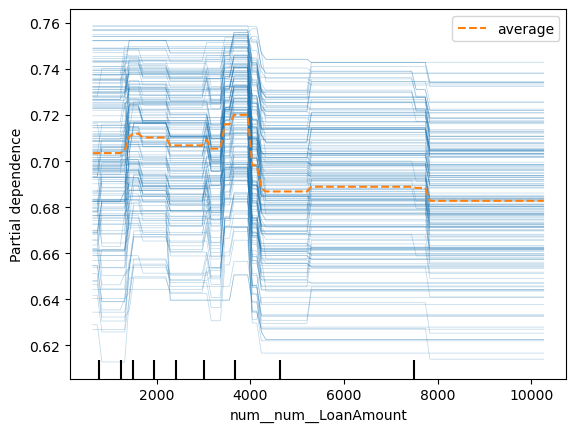

In [96]:
ICE(pipeline_predict, X_test_preprocess, ['num__num__LoanAmount'])